# Modeling March Madness

##### Team Members: Megan Hussey, Anchal Chaudhary, Siddharth Sai

# Introduction : Problem Summary

- Basketball is one of the most popular sports in the United States. 
- In particular, college basketball tournaments capture the attention of sports fans all over the country. 
- The NCAA Division 1 Men’s Basketball Tournament, or March Madness, is a single elimination tournament played every spring featuring 68 college basketball teams. 
- Creating March Madness brackets to estimate the winners and losers of each game in the tournament has become popular even among non-sports fans. 
- For our project, we hope to create models that predict the winning team of any given NCAA game given their past performance. 
- Our models will have real world applications in completing the best possible brackets for March Madness.

# Introduction : Datasets

- Downloaded csv files from the “March Machine Learning Mania 2016” competition via Kaggle.com. 
    - Dataset 1: “RegularSeasonDetailedResults.csv”
        - Includes relevant statistical data of each game in every NCAA season from 2003-2016. 
        - Contains 71,242 rows and 34 attributes
        - Includes field goals, three pointers, free throws, rebounds, assists, turnovers, steals, blocks, and personal fouls for every winning and losing team 
    - Dataset 2: "TourneySeeds.csv"
        - Contains 2082 rows and 3 attributes, which are “Season”, "Seed", and “Team”.  
        - Details a team's seed in March Madness tournament based on a unique letter + number combination

# Introduction : Important Questions

1. Can we predict the score of the winning team through a regression model?
2. Can we classify whether the winning team was playing at home, road, or at a neutral venue?
3. For any given year, can we classify whether the winning team qualifies to the tournament or not? 

# Section 1: Exploratory Data Analysis

In [1]:
#Import required libraries
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import statsmodels.api as sm
import statsmodels.formula.api as smf
import numpy as np
from sklearn import datasets, linear_model
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.neighbors import KNeighborsClassifier
from sklearn import metrics, preprocessing
from sklearn.preprocessing import LabelEncoder
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LinearRegression, Ridge, RidgeCV, Lasso, LassoCV
from sklearn.preprocessing import PolynomialFeatures
from sklearn.feature_selection import SequentialFeatureSelector
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error
from sklearn import datasets, linear_model

from sklearn.tree import DecisionTreeClassifier
from imblearn.over_sampling import SMOTE 
from collections import Counter
from imblearn.under_sampling import RandomUnderSampler #undersampling our biggest data to balance the classes
%matplotlib inline
plt.style.use('seaborn-white')

In [2]:
#Read in RegularSeasonDetailedResults and TourneySeeds csv files (downloaded from kaggle)
ncaa_regular_season_statistics = pd.read_csv("RegularSeasonDetailedResults.csv")
ncaa_tournament_seeds = pd.read_csv("TourneySeeds.csv")

In [3]:
#Check for NaN's across both datasets
missing_values_regular_season_statistics = ncaa_regular_season_statistics.isnull().sum(axis=0)
print("Count of missing values in ncaa_regular_season_statistics dataset:")
print(missing_values_regular_season_statistics) #no missing values

print("\n")

missing_values_tournament_seeds = ncaa_tournament_seeds.isnull().sum(axis=0)
print("Count of missing values in ncaa_tournament_seeds dataset:")
print(missing_values_tournament_seeds) #no missing values

Count of missing values in ncaa_regular_season_statistics dataset:
Season    0
Daynum    0
Wteam     0
Wscore    0
Lteam     0
Lscore    0
Wloc      0
Numot     0
Wfgm      0
Wfga      0
Wfgm3     0
Wfga3     0
Wftm      0
Wfta      0
Wor       0
Wdr       0
Wast      0
Wto       0
Wstl      0
Wblk      0
Wpf       0
Lfgm      0
Lfga      0
Lfgm3     0
Lfga3     0
Lftm      0
Lfta      0
Lor       0
Ldr       0
Last      0
Lto       0
Lstl      0
Lblk      0
Lpf       0
dtype: int64


Count of missing values in ncaa_tournament_seeds dataset:
Season    0
Seed      0
Team      0
dtype: int64


In [4]:
#Change column names in ncaa_regular_season_statistics dataframe to make them more clear
new_column_names = {'Wteam':'W_Team', 'Wscore':'W_Score', 'Lteam':'L_Team', 'Lscore':'L_Score', 'Wloc':'W_Location', 'Numot':'Overtimes',
'Wfgm':'W_Field_Goals_Made', 'Wfga':'W_Field_Goals_Attempts', 'Wfgm3':'W_Three_Pointers_Made', 'Wfga3':'W_Three_Pointers_Attempts', 'Wftm':'W_Free_Throws_Made',
'Wfta':'W_Free_Throws_Attempts', 'Wor':'W_Offensive_Rebounds', 'Wdr':'W_Defensive_Rebounds', 'Wast':'W_Assists', 'Wto':'W_Turnovers', 'Wstl':'W_Steals', 'Wblk':'W_Blocks',
'Wpf':'W_Personal_Fouls', 'Lfgm':'L_Field_Goals_Made', 'Lfga':'L_Field_Goals_Attempts', 'Lfgm3':'L_Three_Pointers_Made', 'Lfga3':'L_Three_Pointers_Attempts', 'Lftm':'L_Free_Throws_Made',
'Lfta':'L_Free_Throws_Attempts', 'Lor':'L_Offensive_Rebounds', 'Ldr':'L_Defensive_Rebounds', 'Last':'L_Assists', 'Lto':'L_Turnovers', 'Lstl':'L_Steals', 'Lblk':'L_Blocks',
'Lpf':'L_Personal_Fouls'}

ncaa_regular_season_statistics.rename(columns=new_column_names, inplace=True)

In [5]:
#Convert H/A/N to Home/Away/Neutral in ncaa_regular_season_statistics dataframe
ncaa_regular_season_statistics["W_Location"].replace({"H": "Home", "A": "Away", "N": "Neutral"}, inplace=True)
print(ncaa_regular_season_statistics["W_Location"].value_counts())

Home       42418
Away       21728
Neutral     7095
Name: W_Location, dtype: int64


In [6]:
#Merge RegularSeasonDetailedResults.csv with TourneySeeds.csv. 
#Get all 'Team' from TourneySeeds.csv and check to see if present in Wteam in RegularSeasonDetailedResults.csv.
#Create a new column called 'WteamTourneyQual' and populate with Yes or No based on match
consolidated_df = ncaa_regular_season_statistics.merge(ncaa_tournament_seeds, how='left', left_on=["Season", "W_Team"], 
                                                       right_on=["Season", "Team"])
consolidated_df['W_Team_Tourney_Qual'] = ['No' if np.isnan(i) else 'Yes' for i in consolidated_df['Team']]
consolidated_df.drop(['Seed','Team'], axis = 1)
consolidated_df = consolidated_df.drop(['Seed','Team'], axis = 1)

In [7]:
#Filter dataframe to only consider the last decade of results - decreases data but dramatically improves performance
consolidated_df = consolidated_df[consolidated_df["Season"] >= 2012]

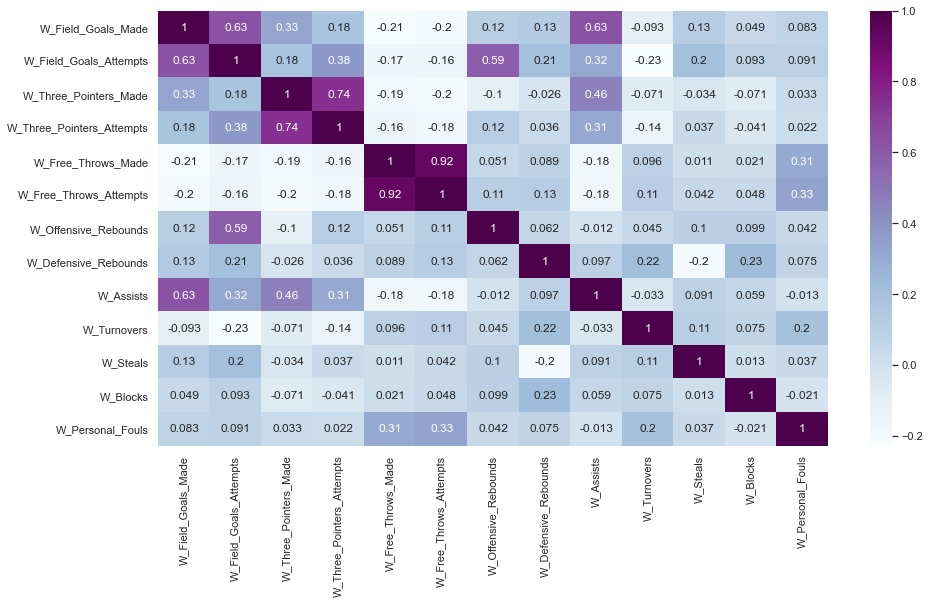

In [8]:
#Visualization 1 - What factors play a role in a winning team's offense?
#Fit a multiple linear regression model and then display a heatmap from the results: 
lm_p4 = smf.ols('W_Score ~ W_Field_Goals_Made + W_Field_Goals_Attempts + W_Three_Pointers_Made + W_Three_Pointers_Attempts + W_Free_Throws_Made + W_Free_Throws_Attempts + W_Offensive_Rebounds + W_Defensive_Rebounds + W_Assists + W_Turnovers + W_Steals + W_Blocks + W_Personal_Fouls', 
consolidated_df[
    ['W_Score', 'W_Field_Goals_Made', 'W_Field_Goals_Attempts', 
     'W_Three_Pointers_Made', 'W_Three_Pointers_Attempts', 'W_Free_Throws_Made', 
     'W_Free_Throws_Attempts', 'W_Offensive_Rebounds', 'W_Defensive_Rebounds', 'W_Assists', 
     'W_Turnovers', 'W_Steals', 'W_Blocks', 'W_Personal_Fouls']]).fit()
results_reg = pd.read_html(lm_p4.summary().tables[1].as_html(), header=0, index_col=0)[0]
positive_coefs = list(results_reg.index)
positive_coefs.pop(0)
#Heatmap to show correlations:
sns.set(rc = {'figure.figsize':(15,8)})
sns.heatmap(consolidated_df[positive_coefs].corr(), annot=True, cmap="BuPu")
plt.show()

From the correlation matrix, there seems to be some strong correlation between the following variables:
W_Field_Goals_Made - W_Field_Goals_Attempts
W_Field_Goals_Made - W_Assists
W_Field_Goals_Attempts - W_Offensive_Rebounds
W_Three_Pointers_Made - W_Three_Pointers_Attempts
W_Free_Throws_Made - W_Free_Throws_Attempts

Text(0.5, 1.02, 'Aggregate Count of Teams Who Qualified for March Madness Tournament In a Given Year')

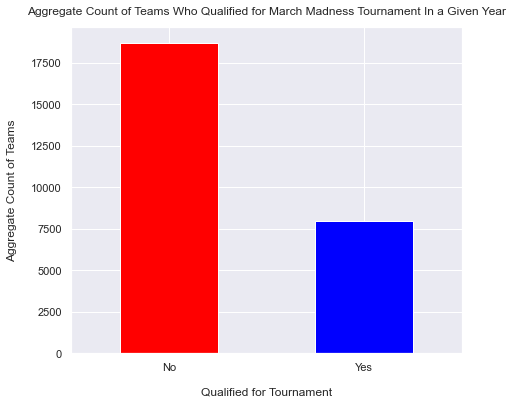

In [9]:
#Visualization 2: Bar graph of count of teams that qualified for march madness vs teams that did not qualify
sns.set(font_scale=1.4)
sns.set(rc = {'figure.figsize':(15,8)})
consolidated_df['W_Team_Tourney_Qual'].value_counts().plot(kind='bar', figsize=(7, 6), rot=0, color=['red', 'blue'])
plt.xlabel("Qualified for Tournament", labelpad=14)
plt.ylabel("Aggregate Count of Teams", labelpad=14)
plt.title("Aggregate Count of Teams Who Qualified for March Madness Tournament In a Given Year", y=1.02)

There are only a subset of winning teams who are able to qualify for the March Madness tournament as it is very selective. As expected, there are more teams who do not qualify for the tournament compared to the teams who do qualify.

In [10]:
#Value counts of W_Score column - target variable for regression
print(consolidated_df['W_Score'].describe())

count    26658.000000
mean        74.669405
std         10.923346
min         34.000000
25%         67.000000
50%         74.000000
75%         82.000000
max        144.000000
Name: W_Score, dtype: float64


The column "W_Score" indicates the number of points that the winning team scored. Based on the above summary, the average score of the winning team is approximately 75 points, and the maximum number of points that any team has scores is 144. The least number of points that any winning team has had is 34 points. Also, the standard deviation is 11.06.

In [11]:
#Value counts of W_Location column - target variable for classification model 1
print(consolidated_df['W_Location'].value_counts())

Home       15614
Away        8268
Neutral     2776
Name: W_Location, dtype: int64


The column "W_Location" indicates whether a team won on their home floor, on the road, or at a neutral venue. Based on the output of value_counts(), a majority of teams won at home or on the road, while some teams (most likely the ones who qualified for the tournament) won at a neutral venue.

In [12]:
#Value counts of W_Team_Tourney_Qual column - target variable for classification model 2
print(consolidated_df['W_Team_Tourney_Qual'].value_counts())

No     18705
Yes     7953
Name: W_Team_Tourney_Qual, dtype: int64


The column "W_Team_Tourney_Qual" indicates whether the winning team qualified for the postseason tournament for that given year. As expected, there are much more teams who do not qualify for the tournament compared to the teams who do qualify. 

# Regression Study : Predict Score of Winning Team

In [13]:
#using label encoder instead of dummy variables to change variables to quant

consolidated_df_regression = consolidated_df

le = LabelEncoder()
consolidated_df_regression["W_Location"] = le.fit_transform(consolidated_df_regression["W_Location"])
consolidated_df_regression["W_Team_Tourney_Qual"] = le.fit_transform(consolidated_df_regression["W_Team_Tourney_Qual"])

In [14]:
#dropping our target variable, tournament qualification and a few other meaningless variables for the model

x = consolidated_df_regression.drop(['W_Score', 'Season', 'Daynum', 'W_Team', 'L_Team', 
                                    'W_Field_Goals_Made',
       'L_Field_Goals_Attempts', 'L_Three_Pointers_Made',
       'L_Three_Pointers_Attempts', 'W_Free_Throws_Made',
       'L_Free_Throws_Attempts', 'W_Offensive_Rebounds',
       'W_Defensive_Rebounds', 'L_Assists', 'W_Turnovers', 'L_Steals',
       'W_Blocks', 'L_Personal_Fouls'], axis = 1) #dropping random columns to balance our dataset best for the regression model

#keeping only the target variable (winning team score)
y = consolidated_df_regression['W_Score']

x.columns

Index(['L_Score', 'W_Location', 'Overtimes', 'W_Field_Goals_Attempts',
       'W_Three_Pointers_Made', 'W_Three_Pointers_Attempts',
       'W_Free_Throws_Attempts', 'W_Assists', 'W_Steals', 'W_Personal_Fouls',
       'L_Field_Goals_Made', 'L_Free_Throws_Made', 'L_Offensive_Rebounds',
       'L_Defensive_Rebounds', 'L_Turnovers', 'L_Blocks',
       'W_Team_Tourney_Qual'],
      dtype='object')

In [15]:
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=4)

In [16]:
#linear regression on training Dataset

lm = LinearRegression()
lm.fit(x_train,y_train) #fitting our x and y 
print(lm.coef_) #printing the coefficients of the model


[ 0.23397766  0.00521642 -0.9000013   0.7991079   1.45772058 -0.38688891
  0.53962638  0.54965277  0.14717322  0.0541341   0.09485529  0.04160522
 -0.01202139 -0.73822176  0.007537   -0.59172753  0.65180297]


In [17]:
#Calculating R squared and MSE
print("Training R-squared: ", r2_score(y_train, lm.predict(x_train)))
print("Testing R-squared: ", r2_score(y_test, lm.predict(x_test)))
print("Train MSE: ", mean_squared_error(y_train, lm.predict(x_train)))
print("Test MSE: ",  mean_squared_error(y_test, lm.predict(x_test)))

Training R-squared:  0.8503756650460499
Testing R-squared:  0.8497515483917073
Train MSE:  17.813423459200685
Test MSE:  18.071085183220504


The linear model appears to be good fit with R-squared values of around 0.85 for both training and testing. 

Furthermore, the train and test MSE are close together (17.81 and 18.07, respectively), further emphasizing the good fit of the model. We should continue to run tests to validate this model, however.

**Variable Selection**

In [18]:
#Using sequential feature selector to build linear regression with 10 feature selection

#Using cross value score to print the predictors in the loop and findng CV errors for each predictor

model= LinearRegression()
cv_error = []
for i in range(1, 11):  #Iterating over 10 features and printing CV scores for each pair of features selected
 sfs = SequentialFeatureSelector(model, 
                                n_features_to_select = i, 
                                direction="forward",
                                scoring='neg_mean_squared_error',
                                cv= 10) 

 sfs = sfs.fit(x,y)
 feature_names = x.columns
 variable = consolidated_df[feature_names[sfs.get_support()]]
 scores = cross_val_score(model, variable, y, cv=10, scoring='neg_mean_squared_error')
 average = np.mean(scores)
 cv_error.append(abs(average))
 print("Features selected by forward sequential selection: "+str(feature_names[sfs.get_support()]))
 print(average) #getting the average CV score of all features selected 
 print('\n')

Features selected by forward sequential selection: Index(['L_Score'], dtype='object')
-68.15441183957043


Features selected by forward sequential selection: Index(['L_Score', 'W_Assists'], dtype='object')
-45.682318557660025


Features selected by forward sequential selection: Index(['L_Score', 'W_Free_Throws_Attempts', 'W_Assists'], dtype='object')
-41.15378908456616


Features selected by forward sequential selection: Index(['L_Score', 'W_Field_Goals_Attempts', 'W_Free_Throws_Attempts',
       'W_Assists'],
      dtype='object')
-34.896652080514244


Features selected by forward sequential selection: Index(['L_Score', 'W_Field_Goals_Attempts', 'W_Free_Throws_Attempts',
       'W_Assists', 'L_Defensive_Rebounds'],
      dtype='object')
-26.335653911152974


Features selected by forward sequential selection: Index(['L_Score', 'W_Field_Goals_Attempts', 'W_Three_Pointers_Made',
       'W_Free_Throws_Attempts', 'W_Assists', 'L_Defensive_Rebounds'],
      dtype='object')
-20.7922113786455

In [19]:
#Calculating CV Errors and plotting number of predictors vs CV errors

min_val = cv_error.index(min(cv_error))
print(min_val)

9


The results above show that the best model is achiveed with 4 set of predictors for our model as that gives the lowest CV error.

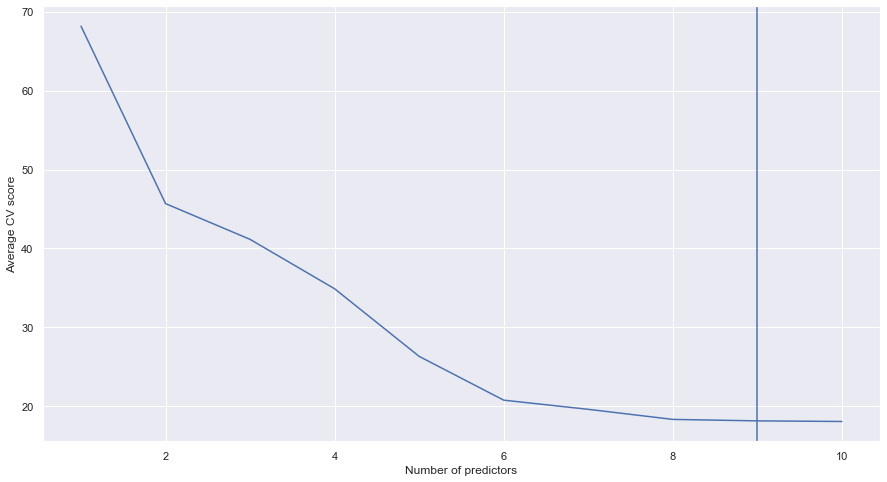

In [20]:

predictors = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10] #creating a list with number of predictors that we got having minimum CV errors
sns.lineplot(x=predictors, y=cv_error) 
plt.xlabel('Number of predictors')
plt.ylabel('Average CV score')
plt.axvline(x = 9) #printing a vertical line showing minimum number of features selected


In [21]:
#Getting R squared and model fitting of the new model with 9 selected features 

x1 = consolidated_df_regression[['L_Score', 'W_Field_Goals_Attempts', 'W_Three_Pointers_Made',
       'W_Three_Pointers_Attempts', 'W_Free_Throws_Attempts', 'W_Assists',
       'W_Steals', 'L_Defensive_Rebounds', 'L_Blocks']]
y1 = consolidated_df_regression['W_Score']
x1_train, x1_test, y1_train, y1_test = train_test_split(x1, y1, test_size=0.2, random_state=1)

lm2 = LinearRegression()
lm2.fit(x1_train,y1_train)
lm2.score(x1_train, y1_train)

0.8489565125358038

Running linear regression with the selected 9 predictors does not seem to have a big impact on our R-squared value.

**Using Ridge Regression to test the model**

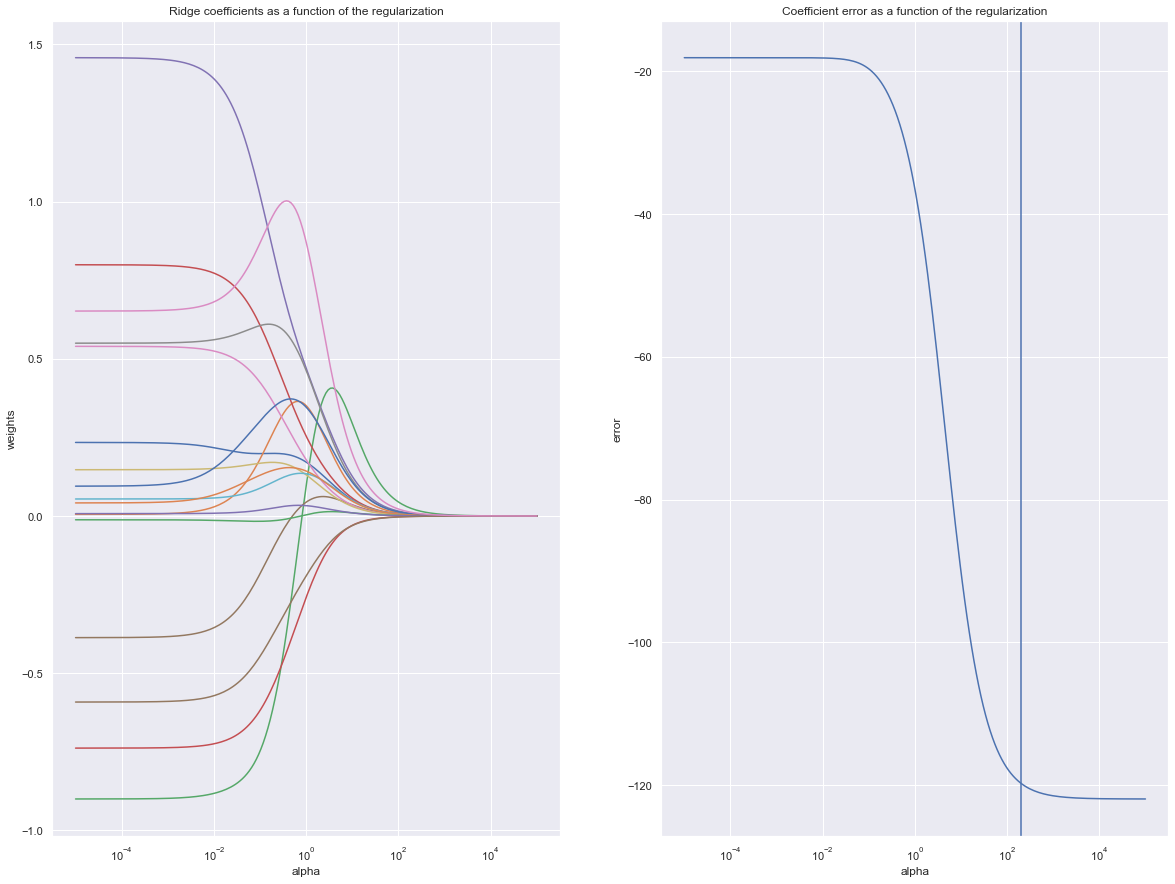

In [22]:
#Warning: Takes a minute or two to run
#Iterating over alpha values and plotting the ridge regression model

model_ridge = Ridge(normalize=True)
coeficients = []
scores_cv = []


alphas = np.logspace(-5, 5, 200)
for a in alphas:
    clf=model_ridge.set_params(alpha=a)
    clf.fit(x_train, y_train)
    coeficients.append(model_ridge.coef_)
    scores = cross_val_score(model_ridge, x, y, cv=5, scoring='neg_mean_squared_error')
    average = np.mean(scores)
    scores_cv.append(average)
    
min_cv_ridge = min(scores_cv)
min_value = scores_cv.index(min(scores_cv))
    
plt.figure(figsize=(20, 15))

plt.subplot(121)
ax = plt.gca()
ax.plot(alphas, coeficients)
ax.set_xscale("log")
plt.xlabel("alpha")
plt.ylabel("weights")
plt.title("Ridge coefficients as a function of the regularization")
plt.axis("tight")

plt.subplot(122)
ax = plt.gca()
ax.plot(alphas, scores_cv)
ax.set_xscale("log")
plt.xlabel("alpha")
plt.ylabel("error")
plt.title("Coefficient error as a function of the regularization")
plt.axis("tight")
plt.axvline(x=min_value)

plt.show()


In [23]:
#Using RidgeCV and calculating best alpha 

model_ridgeCV = RidgeCV(cv=5,normalize=True, alphas = alphas).fit(x_train, y_train)


coefficients=pd.DataFrame(x_train.columns,columns=["feature"])
coefficients["values"] = model_ridgeCV.coef_

print("Ridge - Training R-squared value: "+str(model_ridgeCV.score(x_train,y_train)))
print("Ridge - Testing R-squared value: "+str(model_ridgeCV.score(x_test,y_test)))
print("Ridge - Best Alpha: "+str(model_ridgeCV.alpha_))
print("Ridge - Intercept: "+str(model_ridgeCV.intercept_))

Ridge - Training R-squared value: 0.8503755639430665
Ridge - Testing R-squared value: 0.8497503119169544
Ridge - Best Alpha: 0.00018041864093920718
Ridge - Intercept: 6.134370842437576


In [24]:
#Refitting model with the best alpha

ridge = Ridge(alpha=0.00204, normalize = True)
ridge.fit(x_train,y_train)
y_test_ridge_pred = ridge.predict(x_test)
y_train_ridge_pred = ridge.predict(x_train)

print("Training MSE is: ", mean_squared_error(y_train, y_train_ridge_pred))
print("Testing MSE is: ", mean_squared_error(y_test, y_test_ridge_pred))

Training MSE is:  17.814911137087115
Testing MSE is:  18.074028974890172


**Using Lasso Regression on the model**

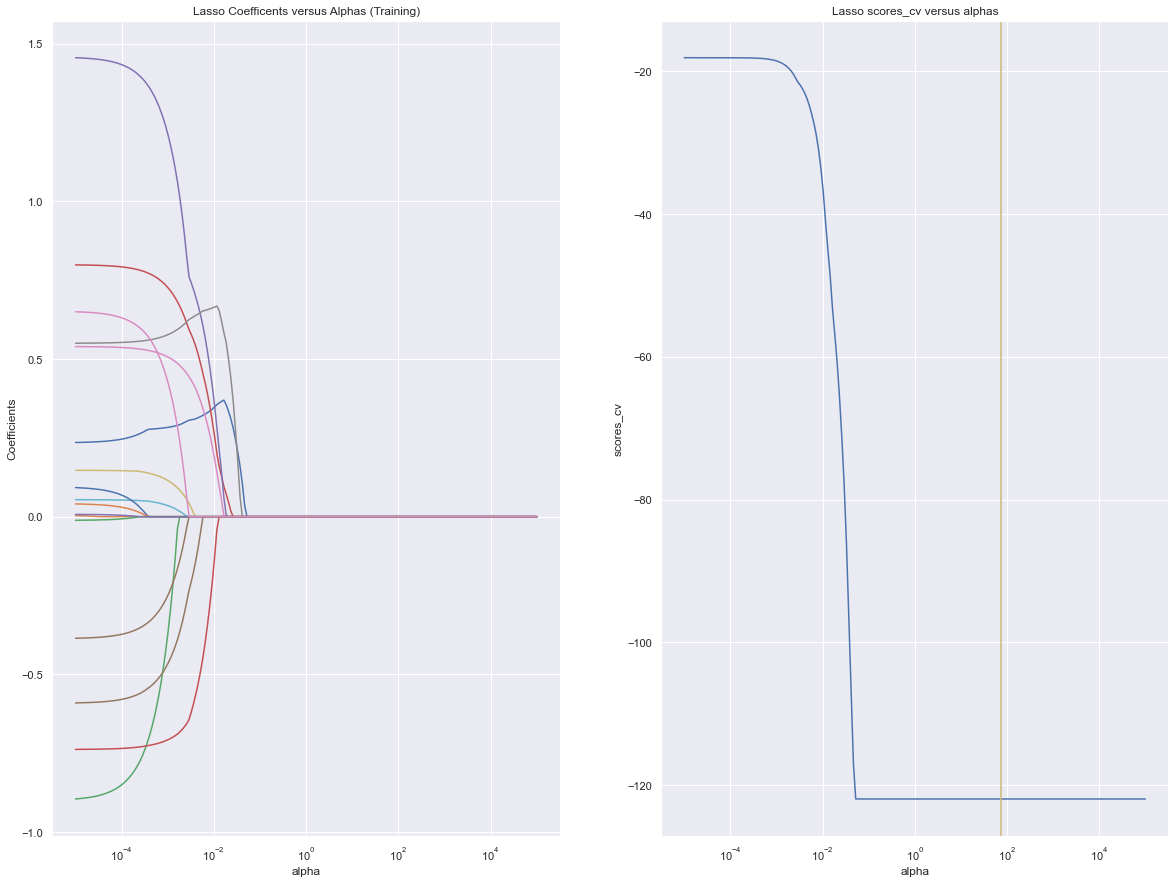

In [25]:
#Warning: Takes a minute or two to run
#Iterating over alpha values and plotting the lasso regression model

model_lasso = Lasso(normalize=True, tol=0.00000000000001, max_iter=1000000000) #to fix the warnings displayed
coefficents = []
scores_cv_lasso = []

alphas = np.logspace(-5, 5, 200)
for a in alphas:
    model_lasso.set_params(alpha=a, tol=0.00000000000001, max_iter=1000000000)
    model_lasso.fit(x_train, y_train)
    coefficents.append(model_lasso.coef_)
    scores = cross_val_score(model_lasso, x, y, cv=5, scoring='neg_mean_squared_error')
    average = np.mean(scores)
    scores_cv_lasso.append(average)
    
min_cv_lasso = min(scores_cv_lasso)

min_value_lasso = scores_cv_lasso.index(min(scores_cv_lasso))
 
plt.figure(figsize=(20, 15))

plt.subplot(121)
ax = plt.gca()
ax.plot(alphas, coefficents)
ax.set_xscale('log')
plt.xlabel('alpha')
plt.ylabel('Coefficients')
plt.title('Lasso Coefficents versus Alphas (Training)')
plt.axis('tight')

plt.subplot(122)
ax = plt.gca()
ax.plot(alphas, scores_cv_lasso, linestyle="-")
ax.set_xscale('log')
plt.xlabel('alpha')
plt.ylabel('scores_cv')
plt.title('Lasso scores_cv versus alphas')
plt.axis('tight')
plt.axvline(x=min_value_lasso,color='y')


plt.show()

In [26]:
#Using LassoCV for regression and calculating best alpha

model_lassoCV= LassoCV(cv=5, normalize=True, alphas = alphas, tol=0.00000000000001, max_iter=1000000000).fit(x_train, y_train)

coefficients_lasso = pd.DataFrame(x_train.columns, columns=["feature"])
coefficients_lasso["values"] = model_lassoCV.coef_

print("Lasso - Training R-squared value: "+str(model_lassoCV.score(x_train,y_train)))
print("Lasso - Testing R-squared value: "+str(model_lassoCV.score(x_test,y_test)))
print("Lasso - Best Alpha: "+str(model_lassoCV.alpha_))
print("Lasso - Intercept: "+str(model_lassoCV.intercept_))

Lasso - Training R-squared value: 0.850374480194649
Lasso - Testing R-squared value: 0.8497576646755473
Lasso - Best Alpha: 1.588565129428053e-05
Lasso - Intercept: 6.164467057038593


In [27]:
#Refitting model with the best alpha

lasso = Lasso(alpha=1e-05, normalize = True, tol=0.00000000000001, max_iter=1000000000)
lasso.fit(x_train,y_train)
y_test_lasso_pred = lasso.predict(x_test)
y_train_lasso_pred = lasso.predict(x_train)

print("Training MSE is: ", mean_squared_error(y_train, y_train_lasso_pred))
print("Testing MSE is: ", mean_squared_error(y_test, y_test_lasso_pred))

Training MSE is:  17.81347935755151
Testing MSE is:  18.07058950521249


In [28]:
#comparing linear regression, ridge and lasso regularization

print("Lasso - Test R-squared: "+str(model_lassoCV.score(x_test,y_test)))
print("Linear Regression R-squared: ", lm.score(x_test,y_test))
print("Ridge - Test R-squared: "+str(model_ridgeCV.score(x_test,y_test)))
print("\n \n")
print("Lasso Testing MSE is: ", mean_squared_error(y_test, y_test_lasso_pred))
print("Linear Regression Test MSE is: ",  mean_squared_error(y_test, lm.predict(x_test)))
print("Ridge Testing MSE is: ", mean_squared_error(y_test, y_test_ridge_pred))


Lasso - Test R-squared: 0.8497576646755473
Linear Regression R-squared:  0.8497515483917073
Ridge - Test R-squared: 0.8497503119169544

 

Lasso Testing MSE is:  18.07058950521249
Linear Regression Test MSE is:  18.071085183220504
Ridge Testing MSE is:  18.074028974890172


In [29]:
#Predicting the winning score using linear regression model

pred_score = lm.predict(x_test)

sortedscores = np.sort(pred_score)

print("Top 10 predicted winning scores are: \n", sortedscores[-10:])
print("-------------")

print("Bottom 10 predicted winning scores are: \n", sortedscores[:10])


Top 10 predicted winning scores are: 
 [108.99896464 110.03766973 110.33834331 110.75679428 112.67765213
 112.76524083 115.73075834 117.5634355  117.80107282 121.95555077]
-------------
Bottom 10 predicted winning scores are: 
 [41.7561208  44.82642227 44.92388458 45.00524207 45.73581061 46.03172647
 46.06422748 46.78112572 46.81658709 47.92494717]


## Interpretation and Analysis of Regression Models 

 - The first model that we picked was linear regression to get an understanding of the impact of different features/variables on the target variable which is the score of the winning team (WScore).
 
 - The R-squared of our initial linear regression was very high (0.85). We continued to run tests to validate this model as being a good fit for our data.

 - We moved on to find the best features using sequential feature selection that simulateously gave Cross Validation Scores too by iterating it over 10 features.

 - The results of sequential feature selection show that the best model is achieved with 9 set of predictors for our model as that gives the lowest CV error of -18.170.

 - Using this information, we fit our linear regression model and calculated the R-squared value, which remained at 0.84/0.85.

 - The next model that we tested was polynomial regression. However, since the dataset is huge, the code was crashing the system and could not iterate beyond degree 2.

 - We then used methods of regularization i.e Ridge and Lasso models. These models showed the best alpha scores, and depicted which feature could be shrunk to better predict WScore.

 - We used RidgeCV to calculate best alapha and R-squared value which is equal to 0.849. We then refitted our model with the best alpha value obtained and calculated MSE which is 18.07.

 - Similarly, tested using LassoCV to get the R-squared value of 0.849 and MSE of 18.07 after fitting in best alpha value (these values were the same as from Ridge).

 - Of all the three models tested, all 3 had extremely similar R-squared values. For simplicity, we will choose the linear regression as the final model.

 - Using Linear Regression as the final model, we predicted the top ten winning score for the team and bottom ten winning score.

# Classification Study 1 : Predict Whether the Winning Team Played At Home, Away, or at a Neutral Venue

In [30]:
consolidated_df_classification_1 = consolidated_df

le = LabelEncoder()
consolidated_df_classification_1["W_Team_Tourney_Qual"] = le.fit_transform(consolidated_df_classification_1["W_Team_Tourney_Qual"])

X_classification_2 = consolidated_df_classification_1.drop(['W_Team_Tourney_Qual', 'Season', 'Daynum'], axis = 1) #dropping our target variable, tournament qualification and a few other meaningless variables for the model
y_classification_2 = consolidated_df_classification_1['W_Team_Tourney_Qual'] #keeping only the target variable (tournament qualification - yes or no)

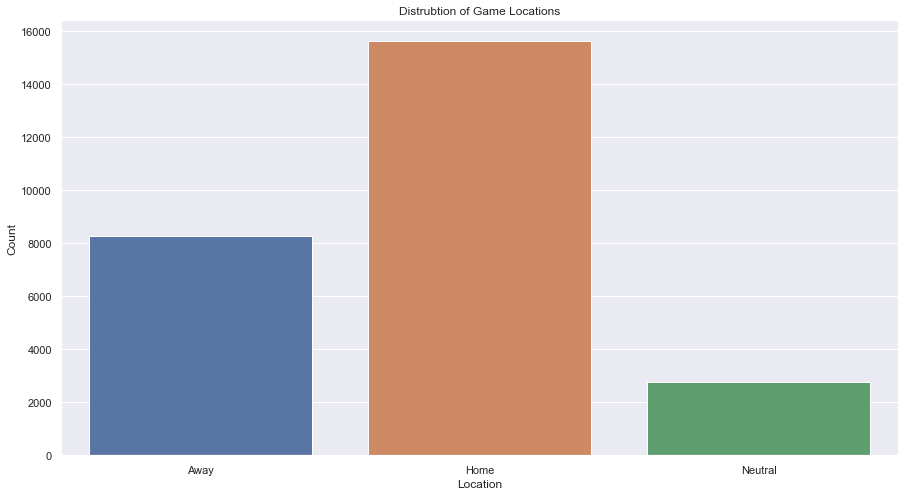

In [31]:
sns.countplot(x="W_Location", data=consolidated_df_classification_1).set(
    title = 'Distrubtion of Game Locations', xlabel = 'Location', ylabel = 'Count', xticklabels=["Away", "Home", "Neutral"]) 
sns.set(rc = {'figure.figsize':(15,8)})
#quick barplot to show the distribution of location

In [32]:
consolidated_df_classification_1['W_Location'].replace({'Away': 0, 'Home': 1, 'Neutral': 2}, inplace=True) #have to make these quant variables to work with our model
x = consolidated_df_classification_1.drop(['W_Location', 'Season', 'Daynum'], axis = 1) #dropping our target variable, tournament qualification and a few other meaningless variables for the model
y = consolidated_df_classification_1['W_Location'] #keeping only the target variable (tournament qualification - yes or no)
y.value_counts()

1    15614
0     8268
2     2776
Name: W_Location, dtype: int64

In [33]:
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=1)
Counter(y_train)
Counter(y_test) #we can see our test/train is imbalanced

Counter({0: 1607, 1: 3130, 2: 595})

In [34]:
#using a technique to undersample the category with the highest number of observations (home games)
under_sampler = RandomUnderSampler(random_state=42)
x_res, y_res = under_sampler.fit_resample(x_train, y_train)
print(f"Training target statistics: {Counter(y_res)}")
print(f"Testing target statistics: {Counter(y_test)}")

Training target statistics: Counter({0: 2181, 1: 2181, 2: 2181})
Testing target statistics: Counter({1: 3130, 0: 1607, 2: 595})


Accuracy Score of KNN:  0.386721680420105
[[ 810  474  323]
 [1328 1117  685]
 [ 261  199  135]]
              precision    recall  f1-score   support

           0      0.338     0.504     0.404      1607
           1      0.624     0.357     0.454      3130
           2      0.118     0.227     0.155       595

    accuracy                          0.387      5332
   macro avg      0.360     0.363     0.338      5332
weighted avg      0.481     0.387     0.406      5332



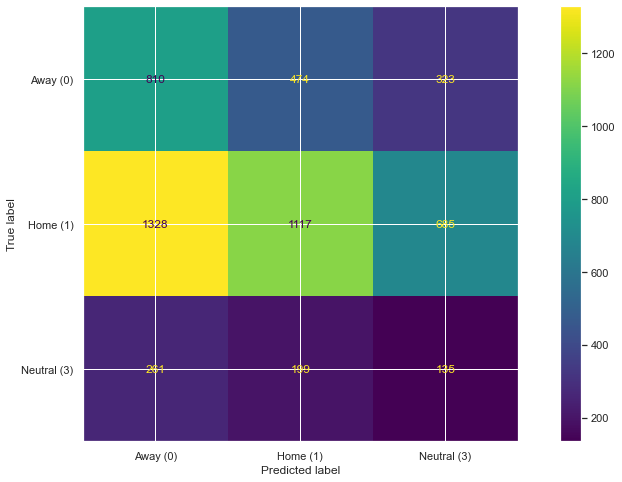

In [35]:
#model 1: KNN
knn_location = KNeighborsClassifier()
knn_location.fit(x_res, y_res)
y_pred = knn_location.predict(x_test)
accuracy_score = metrics.accuracy_score(y_test, y_pred)
print("Accuracy Score of KNN: ", accuracy_score)

cm_location = confusion_matrix(y_test,y_pred)

print(cm_location)
print(classification_report(y_test, y_pred, digits=3))
display_cm_location = ConfusionMatrixDisplay(confusion_matrix=cm_location, display_labels = ['Away (0)','Home (1)', 'Neutral (3)'])
display_cm_location.plot()

 - This KNN model has a poor accurarcy score of 0.387 is having trouble classifying the locations of away (0) and neutral (2) 
 
 - It is having an easier time classifying if the location was a home game (1), probably due to the fact that more games were played at the winning team's home location.

Accuracy Score of NB model:  0.6146371020522484
              precision    recall  f1-score   support

           0      0.484     0.456     0.469      1607
           1      0.733     0.536     0.620      3130
           2      0.156     0.400     0.224       595

    accuracy                          0.497      5332
   macro avg      0.458     0.464     0.438      5332
weighted avg      0.594     0.497     0.530      5332



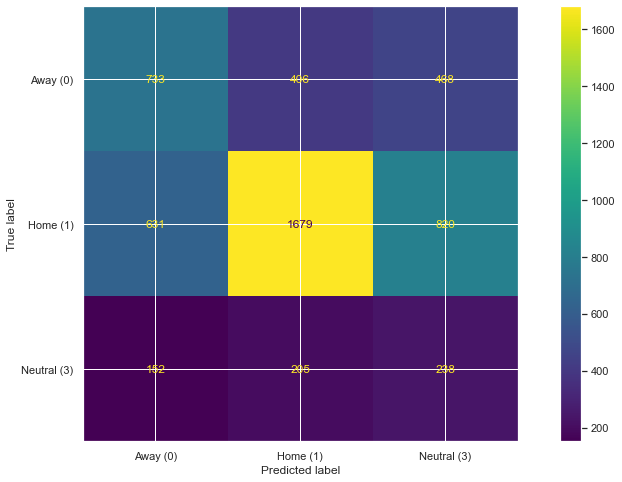

In [36]:
#fitting model 2: GB
modelNB = GaussianNB()
modelNB.fit(x_res, y_res) #fitting our model with balanced training
y_pred2 = modelNB.predict(x_test) #predicting on test
CV_error = np.mean(cross_val_score(modelNB, x, y, cv=10)) #mean of CV scores to find the accuracy
print("Accuracy Score of NB model: ",CV_error)

cm_location2 = confusion_matrix(y_test,y_pred2) #confusion matrix
print(classification_report(y_test, y_pred2, digits=3))

display_cm_location2 = ConfusionMatrixDisplay(confusion_matrix=cm_location2,display_labels = ['Away (0)','Home (1)', 'Neutral (3)'])
display_cm_location2.plot() #confusion matrix plot

 - This model has a better accuracy score than from KNN (0.497). 
 
 - It also does a better job classifying away games (0) and games in neutral locations (2).

In [37]:
#Final model to try: RF classifier
rf = RandomForestClassifier(random_state=1, n_jobs = -1)
rf.fit(x_res, y_res)
y_pred3 = rf.predict(x_test)
print(classification_report(y_test, y_pred3, digits = 3)) 

              precision    recall  f1-score   support

           0      0.450     0.507     0.477      1607
           1      0.743     0.498     0.596      3130
           2      0.155     0.370     0.219       595

    accuracy                          0.487      5332
   macro avg      0.449     0.458     0.431      5332
weighted avg      0.589     0.487     0.518      5332



This model is extremely similar to NB with an accuracy score of (.487). In addition, the weighted average for Naive Bayes is slightly higher than that of Random Forest, meaning the RF model probably has lower f1 scores overall and may be performing slightly better. We should move forward with the RF model tuning using tools from the course to see if we can improve precision scores (especially with away and neutral locations) and get the accuracy score higher.

The maximum accuracy is -1.156357121180288 when number of trees = 100


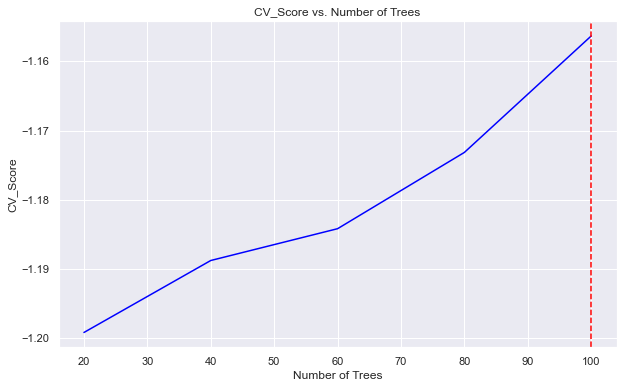

In [38]:
cv_scores = [] #empty lists of cv scores and number of trees to later append to
trees = []
for i in range(20,101,20): #I chose to jump every 20 trees so the code does not run forever (anything below that seemed to take 5+ minutes)
    trees.append(i) #appending our number of trees to the trees list
    rf_clf = RandomForestClassifier(n_estimators=i, random_state=1)
    rf_clf.fit(x_res,y_res)
    cv_scores_rfc = np.mean(cross_val_score(rf_clf, x_res, y_res, cv=10,scoring='neg_mean_squared_error')) #code taken from HW2 and modified
    cv_scores.append(cv_scores_rfc) #appending our cv score averages to the CV score list
    
zipped_list = [(i,j) for i,j in zip(trees,cv_scores)] #zipping the lists together so our lambda function works on just the one list
best_tree = sorted(zipped_list, key = lambda i: i[1], reverse = True)[0][0] 
best_cv = sorted(zipped_list, key = lambda i: i[1], reverse = True)[0][1] 

plt.figure(figsize=(10,6)) #making a plot, code was taken from HW2
plt.plot(range(20,101,20),cv_scores,color='blue', linestyle='solid')
plt.title('CV_Score vs. Number of Trees')
plt.xlabel('Number of Trees')
plt.ylabel('CV_Score')
plt.axvline(x=best_tree,linestyle='--',color="red")
print("The maximum accuracy is {} when number of trees = {}".format(best_cv,best_tree))

In [39]:
#Tuning the model
rf_tuned = RandomForestClassifier(n_estimators=best_tree, random_state=1) 
rf_tuned.fit(x_res,y_res)
y_predict_tuned = rf_tuned.predict(x_test)

#printing out a classification report with our best model (number of trees at 100)
print(classification_report(y_test, y_predict_tuned, digits = 3)) 

              precision    recall  f1-score   support

           0      0.450     0.507     0.477      1607
           1      0.743     0.498     0.596      3130
           2      0.155     0.370     0.219       595

    accuracy                          0.487      5332
   macro avg      0.449     0.458     0.431      5332
weighted avg      0.589     0.487     0.518      5332



Text(0.5, 0, 'Features')

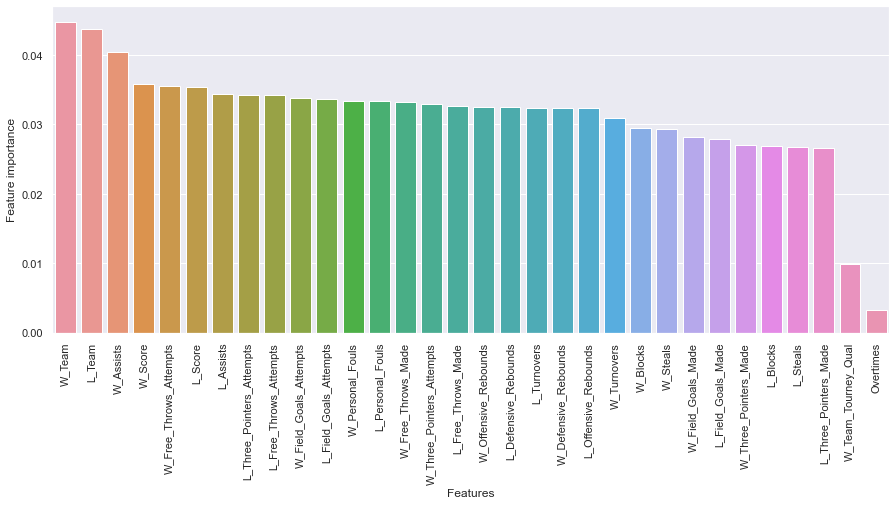

In [40]:
#Feature Selection
forest_importances = pd.DataFrame({'features': x_res.columns, 'importances': rf.feature_importances_ })
fig,ax = plt.subplots(figsize=(15,6))
sns.barplot(x="features",y="importances" ,data=forest_importances, order=forest_importances.sort_values('importances',ascending = False).features, ax=ax)
plt.xticks(rotation=90)
plt.ylabel("Feature importance")
plt.xlabel("Features")

Most features seem relatively important in the model, but we should drop W_Team_Tourney_Qual and Overtimes to see if this helps improve our accuracy. These features seem least important overall.

In [41]:
x2 = x.drop(['W_Team_Tourney_Qual', 'Overtimes'], axis = 1) 
print(x2.columns)

Index(['W_Team', 'W_Score', 'L_Team', 'L_Score', 'W_Field_Goals_Made',
       'W_Field_Goals_Attempts', 'W_Three_Pointers_Made',
       'W_Three_Pointers_Attempts', 'W_Free_Throws_Made',
       'W_Free_Throws_Attempts', 'W_Offensive_Rebounds',
       'W_Defensive_Rebounds', 'W_Assists', 'W_Turnovers', 'W_Steals',
       'W_Blocks', 'W_Personal_Fouls', 'L_Field_Goals_Made',
       'L_Field_Goals_Attempts', 'L_Three_Pointers_Made',
       'L_Three_Pointers_Attempts', 'L_Free_Throws_Made',
       'L_Free_Throws_Attempts', 'L_Offensive_Rebounds',
       'L_Defensive_Rebounds', 'L_Assists', 'L_Turnovers', 'L_Steals',
       'L_Blocks', 'L_Personal_Fouls'],
      dtype='object')


In [42]:
#resetting our train and test split:
x_train2, x_test2, y_train2, y_test2 = train_test_split(x2, y, test_size=0.2, random_state=1)

#Balancing the new train and test sets:
x_res2, y_res2 = under_sampler.fit_resample(x_train2, y_train2)
print(f"Training target statistics: {Counter(y_res2)}")
print(f"Testing target statistics: {Counter(y_test2)}")

Training target statistics: Counter({0: 2181, 1: 2181, 2: 2181})
Testing target statistics: Counter({1: 3130, 0: 1607, 2: 595})


In [43]:
#Fitting another RF model without the two variables dropped: 
rf_tuned = RandomForestClassifier(random_state=1, n_jobs = -1)
rf_tuned.fit(x_res2, y_res2)
y_pred4 = rf_tuned.predict(x_test2)
print(classification_report(y_test2, y_pred4, digits = 3)) 

              precision    recall  f1-score   support

           0      0.449     0.502     0.474      1607
           1      0.742     0.501     0.598      3130
           2      0.136     0.324     0.191       595

    accuracy                          0.482      5332
   macro avg      0.442     0.443     0.421      5332
weighted avg      0.586     0.482     0.515      5332



# Takeaways from Classification Study 1

 - Interestingly, our accuracy went down when trying to model tune with CV and feature selection 
 
 - Our original random forest model still has the highest accurarcy score after model tuning but is still lower than Naive Bayes
 
 - We should therefore choose Naive Bayes as our final model for classifying location (accuracy score: 0.497) for simplicity. 
 
 
 - Limitations: 
    - Had to balance the test/train groups which may have led to a slight misrepresentation of the results 
    - Code took too long to run in some cases, especially in the case of testing for optimal number of trees. May have been higher than 100. 
    - Naive Bayes has limited tuning parameters

# Classification Study 2 : Predict Whether the Winning Team Qualified to the March Madness Tournament

In [44]:
#using label encoder instead of dummy variables to change variables to quant
#pulling all the categorical variables that need to be recoded
#changing the categorical variables to quant in this loop

consolidated_df_classification_2 = consolidated_df

le = LabelEncoder()
consolidated_df_classification_2["W_Location"] = le.fit_transform(consolidated_df_classification_2["W_Location"])
consolidated_df_classification_2["W_Team_Tourney_Qual"] = le.fit_transform(consolidated_df_classification_2["W_Team_Tourney_Qual"])

X_classification_2 = consolidated_df_classification_2.drop(['W_Team_Tourney_Qual', 'Season', 'Daynum'], axis = 1) #dropping our target variable, tournament qualification and a few other meaningless variables for the model
y_classification_2 = consolidated_df_classification_2['W_Team_Tourney_Qual'] #keeping only the target variable (tournament qualification - yes or no)

In [45]:
sm = SMOTE(random_state=42)
X_classification_2_sm, y_classification_2_sm = sm.fit_resample(X_classification_2, y_classification_2)
print("Shape of X_classification_2 before SMOTE: {}".format(X_classification_2.shape))
print("\n")
print("Shape of X_classification_2 after SMOTE: {}".format(X_classification_2_sm.shape))
print("\n")
print("Balance of positive and negative classes (%): \n{}".format(y_classification_2_sm.value_counts(normalize=True) * 100))

Shape of X_classification_2 before SMOTE: (26658, 32)


Shape of X_classification_2 after SMOTE: (37410, 32)


Balance of positive and negative classes (%): 
0    50.0
1    50.0
Name: W_Team_Tourney_Qual, dtype: float64


In [46]:
X_classification_2_train_sm, X_classification_2_test_sm, y_classification_2_train_sm, y_classification_2_test_sm = train_test_split(X_classification_2_sm, y_classification_2_sm, test_size=0.2, random_state=1)
# nan = X_classification_2_sm.isnull().sum() #making sure there are no nans for the model.
# print(nan) #no missing values

Accuracy: 0.6056863184328496


              precision    recall  f1-score   support

           0      0.652     0.427     0.516      3744
           1      0.574     0.772     0.658      3738

    accuracy                          0.599      7482
   macro avg      0.613     0.599     0.587      7482
weighted avg      0.613     0.599     0.587      7482



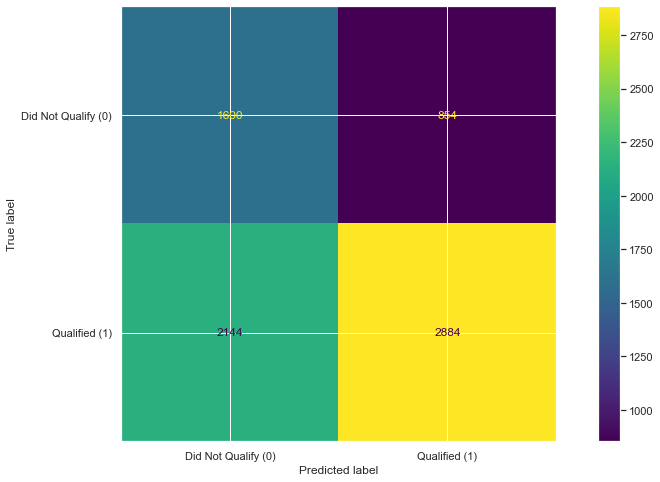

In [47]:
#Naive Bayes Classifier
modelNB_tourney_2 = GaussianNB()
CV_error_NB_tourney_2 = np.mean(cross_val_score(modelNB_tourney_2, X_classification_2_train_sm, y_classification_2_train_sm, cv=10))
print("Accuracy: {}".format(CV_error_NB_tourney_2))
print("\n")

modelNB_tourney_2.fit(X_classification_2_train_sm, y_classification_2_train_sm)
y_pred_nb_2 = modelNB_tourney_2.predict(X_classification_2_test_sm)

nb_tourney_cm_2 = confusion_matrix(y_classification_2_test_sm, y_pred_nb_2).T
print(classification_report(y_classification_2_test_sm, y_pred_nb_2, digits=3))

display_cm_region_nb_2 = ConfusionMatrixDisplay(confusion_matrix=nb_tourney_cm_2, display_labels = ['Did Not Qualify (0)','Qualified (1)'])
display_cm_region_nb_2.plot()

Fitting 3 folds for each of 120 candidates, totalling 360 fits
              precision    recall  f1-score   support

           0       0.64      0.62      0.63      3744
           1       0.63      0.65      0.64      3738

    accuracy                           0.63      7482
   macro avg       0.63      0.63      0.63      7482
weighted avg       0.63      0.63      0.63      7482



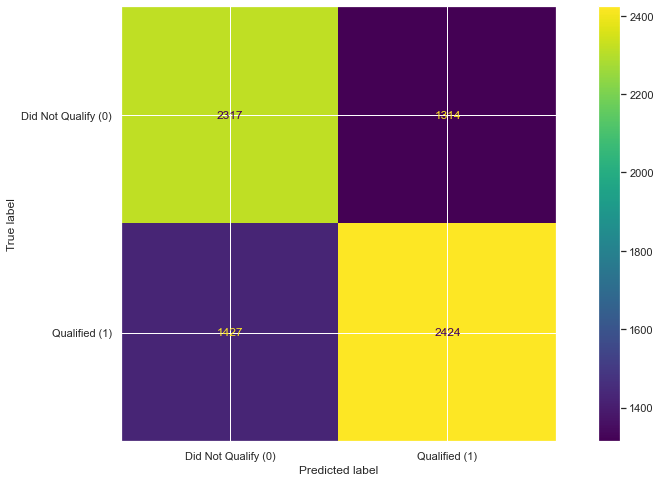

In [48]:
#Decision Tree Classifier with GridSearchCV

param_grid = {'max_depth': range(2, 10, 2), 'max_features': range(2, len(X_classification_2.columns))}

dt_classifier_gscv_2 = DecisionTreeClassifier(random_state=1)
grid_search_gsvc = GridSearchCV(estimator = dt_classifier_gscv_2, param_grid = param_grid, cv = 3, n_jobs = -1, verbose = 2)
grid_search_gsvc.fit(X_classification_2_train_sm, y_classification_2_train_sm)
dt_classifier_gscv_retrained_2 = DecisionTreeClassifier(random_state=1, **grid_search_gsvc.best_params_)

dt_classifier_gscv_retrained_2.fit(X_classification_2_train_sm, y_classification_2_train_sm)
dt_classifier_prediction_gscv_2 = dt_classifier_gscv_retrained_2.predict(X_classification_2_test_sm)

#How good are classification results?
dtc_tourney_cm_2 = confusion_matrix(y_classification_2_test_sm, dt_classifier_prediction_gscv_2).T
print(classification_report(y_classification_2_test_sm, dt_classifier_prediction_gscv_2))

display_cm_region_dtc_2 = ConfusionMatrixDisplay(confusion_matrix=dtc_tourney_cm_2, display_labels = ['Did Not Qualify (0)','Qualified (1)'])
display_cm_region_dtc_2.plot()

The maximum accuracy is -0.25330793905372895 when n_estimators = 100
              precision    recall  f1-score   support

           0       0.78      0.78      0.78      3744
           1       0.78      0.78      0.78      3738

    accuracy                           0.78      7482
   macro avg       0.78      0.78      0.78      7482
weighted avg       0.78      0.78      0.78      7482



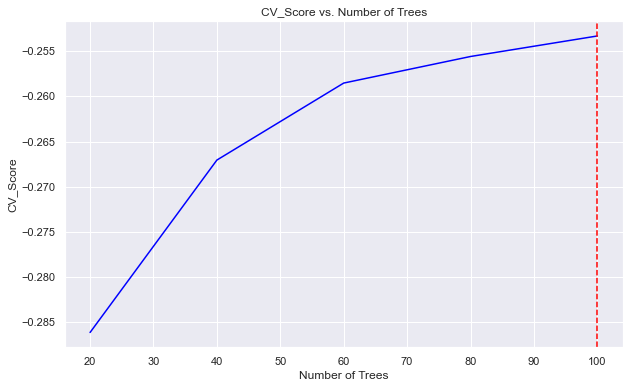

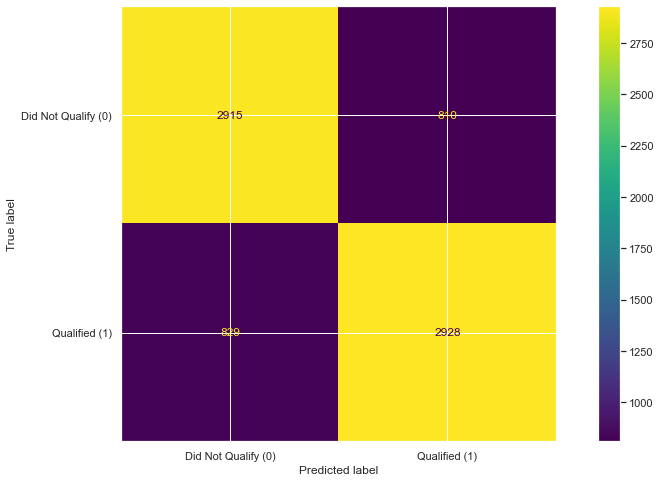

In [49]:
#Random Forest Classifier
cv_scores = []
i_list = []
for i in range(20,101,20):
    i_list.append(i)
    rf_classifier_tourney_2 = RandomForestClassifier(n_estimators=i, random_state=1, n_jobs = -1)
    rf_classifier_tourney_2.fit(X_classification_2_train_sm, y_classification_2_train_sm)
    cv_scores_rfc = np.mean(cross_val_score(rf_classifier_tourney_2, X_classification_2_train_sm, y_classification_2_train_sm, cv=3, scoring='neg_mean_squared_error'))
    cv_scores.append(cv_scores_rfc)
    
paired_list = [(i,j) for i,j in zip(i_list,cv_scores)]
best_i = sorted(paired_list, key = lambda i: i[1], reverse = True)[0][0]
best_acc = sorted(paired_list, key = lambda i: i[1], reverse = True)[0][1]

plt.figure(figsize=(10,6))
plt.plot(range(20,101,20),cv_scores,color='blue', linestyle='solid')
plt.title('CV_Score vs. Number of Trees')
plt.xlabel('Number of Trees')
plt.ylabel('CV_Score')
plt.axvline(x=best_i,linestyle='--',color="red")
print("The maximum accuracy is {} when n_estimators = {}".format(best_acc,best_i))

rf_classifier_updated_tourney_2 = RandomForestClassifier(n_estimators=best_i, random_state=1, n_jobs = -1)
rf_classifier_updated_tourney_2.fit(X_classification_2_train_sm, y_classification_2_train_sm)
rf_classifier_updated_prediction_2 = rf_classifier_updated_tourney_2.predict(X_classification_2_test_sm)

#How good are the classification results
rf_tourney_cm_2 = confusion_matrix(y_classification_2_test_sm, rf_classifier_updated_prediction_2).T
print(classification_report(y_classification_2_test_sm, rf_classifier_updated_prediction_2))

display_cm_region_rf_2 = ConfusionMatrixDisplay(confusion_matrix = rf_tourney_cm_2, display_labels = ['Did Not Qualify (0)','Qualified (1)'])
display_cm_region_rf_2.plot()

# Takeaways from Classification Study 2

 - Classification 2 - Naive Bayes Classifier:
    - Accuracy: 0.599
    - f1-score for 0: 0.516
    - f1-score for 1: 0.658

 - Classification 2 - Decision Tree Classifier:
    - Accuracy: 0.63
    - f1-score for 0: 0.63
    - f1-score for 1: 0.64

 - Classification 2 - Random Forest Classifier: 
    - Accuracy: 0.78
    - f1-score for 0: 0.78
    - f1-score for 1: 0.78


- Based on the data, Random Forest Classifier seemed to have performed the best.


- HOWEVER - Random Forest Classifier and Decision Tree Classifier were not fully optimized and so we have to be cautious about these results. In this case, the Naive Bayes Classifier is the best model in this case, even though it has the lowest accuracy and f1-scores, as it is fully optimized and is able to run well even with a large dataset so the results are not skewed.

# Section 4 : Future Work

**Restrictions/Constraints:**
- Initial consolidated dataframe was 71,214 rows which led to slow performance across all models
- Reducing dataframe to 26,658 records significantly improved performance but led to loss of important records
    - KNN Classifier 2 -->  Range of trees was reduced from (20,500) to (20,100) due to volume of records
        -  Model accuracy may not be perfect
    
    
    
**If you had more time what else could you do?**
- Implement Python libraries such as Dask and Vaex
    - Allows for parallel computing which optimizes performance and uses less memory
- Access data from PostgreSQL relational database using sqlalchemy library



**Improvements To Models?**
- Perform feature selection for all Decision Tree and Random Forest Classifier models
    - Potentially improves model accuracy and reduces dimension of training dataset, leading to less computational strain

## 7) References

1. **Used majority of our code from homeworks, labs, and in-class exercises**
2. https://www.geeksforgeeks.org/how-to-rename-multiple-column-headers-in-a-pandas-dataframe/
3. https://stackoverflow.com/questions/40389018/dropping-multiple-columns-from-a-data-frame-using-python
4. https://www.python-graph-gallery.com/3-control-color-of-barplots
5. https://www.kite.com/python/answers/how-to-replace-column-values-in-a-pandas-dataframe-in-python
6. https://towardsdatascience.com/how-to-effortlessly-handle-class-imbalance-with-python-and-smote-9b715ca8e5a7
7. https://www.tutorialspoint.com/get-first-element-with-maximum-value-in-list-of-tuples-in-python
8. https://stackoverflow.com/questions/61224618/grid-search-parameters-for-decision-tree
9. https://cmdlinetips.com/2018/02/how-to-subset-pandas-dataframe-based-on-values-of-a-column/
10. https://stackoverflow.com/questions/54150147/classification-report-precision-and-f-score-are-ill-defined https://towardsdatascience.com/how-to-balance-a-dataset-in-python-36dff9d12704
11. https://www.linkedin.com/pulse/how-handle-large-data-files-machine-learning-rohan-chikorde/
12. https://stackoverflow.com/questions/40489017/how-to-enable-scrolling-in-slides-for-a-jupyter-notebook
13. https://stackoverflow.com/questions/61991736/how-to-relabel-bars-in-seaborn-plot

jupyter nbconvert March_Madness_Final_Project_CLEAN.ipynb --to slides --post serve --SlidesExporter.reveal_scroll=True